<a href="https://colab.research.google.com/github/jeffreyhuang45/oreilly-retrieval-augmented-gen-ai/blob/main/First_Steps_with_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai pinecone-client google-search-results alpaca-trade-api supabase diffusers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of realtime to determi

In [ ]:
from supabase import create_client, Client
import datetime
import re
from copy import copy
from functools import lru_cache

import sys
from io import StringIO
from typing import Dict, Optional, Any
from google.colab import userdata
from openai import OpenAI
import os
from diffusers import StableDiffusionPipeline
import torch

from serpapi import GoogleSearch

from pydantic import BaseModel, Field
from typing import List, Dict, Tuple

In [ ]:
url: str = userdata.get('SUPABASE_URL')
key: str = userdata.get('SUPABASE_API_KEY')
supabase: Client = create_client(url, key)

In [ ]:
class ToolInterface(BaseModel):
    name: str
    description: str

    def use(self, input_text: str) -> str:
        raise NotImplementedError("use() method not implemented")  # Implement in subclass

class PythonREPLTool(ToolInterface):
    """A tool for running python code in a REPL."""

    globals: Optional[Dict] = Field(default_factory=dict, alias="_globals")
    locals: Optional[Dict] = Field(default_factory=dict, alias="_locals")

    name: str = "Python REPL"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        "Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out "
        "with `print(...)`. Include examples of using the code and print "
        "the output."
    )

    def run(self, command: str) -> str:
        """Run command with own globals/locals and returns anything printed."""
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        try:
            exec(command, self.globals, self.locals)
            sys.stdout = old_stdout
            output = mystdout.getvalue()
        except Exception as e:
            sys.stdout = old_stdout
            output = str(e)
        return output

    def use(self, input_text: str) -> str:
        input_text = input_text.strip().replace("```python" , "")
        input_text = input_text.strip().strip("```")
        return self.run(input_text)


In [ ]:
repl_tool = PythonREPLTool()
result = repl_tool.use('print(1+1)')
print(result)
assert result == "2\n"


2



In [ ]:
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

class ChatLLM(BaseModel):
    model: str = 'gpt-3.5-turbo'
    temperature: float = 0.0

    def generate(self, prompt: str, stop: List[str] = None):
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params' : {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'AGENT'
        }).execute()
        return response.choices[0].message.content

In [ ]:
llm = ChatLLM()
result = llm.generate(prompt='Who is the president of Turkey?')
print(result)

The current president of Turkey is Recep Tayyip Erdoğan.


In [ ]:
import PIL
import matplotlib.pyplot as plt

In [ ]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
OBSERVATION_TOKEN = "Observation:"
THOUGHT_TOKEN = "Thought:"
PROMPT_TEMPLATE = """Today is {today} and you can use tools to get new information. Response the user's input as best as you can using the following tools:

{tool_description}

Use the following format:

User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the action to take, exactly one element of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
Thought: Now comment on what you want to do next.
Action: the next action to take, exactly one element of [{tool_names}]
Action Input: the input to the next action
Observation: the result of the next action
... (this Thought/Action/Action Input/Observation repeats until you are sure of the answer)
Assistant Thought: I have enough information to respond to the user's input.
Assistant Response: your final answer to the original input question

Begin:

{previous_responses}
"""

class Agent(BaseModel):
    llm: ChatLLM
    tools: List[ToolInterface]
    prompt_template: str = PROMPT_TEMPLATE
    max_loops: int = 5
    # The stop pattern is used, so the LLM does not hallucinate until the end
    stop_pattern: List[str] = [f'\n{OBSERVATION_TOKEN}', f'\n\t{OBSERVATION_TOKEN}']
    human_responses: List[str] = []
    ai_responses: List[str] = []
    pretty_responses: List[str] = []
    verbose: bool = False

    @property
    def tool_description(self) -> str:
        return "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

    @property
    def tool_names(self) -> str:
        return ", ".join([tool.name for tool in self.tools])

    @property
    def tool_by_names(self) -> Dict[str, ToolInterface]:
        return {tool.name: tool for tool in self.tools}

    def run(self, question: str):
        self.ai_responses.append(f'User Input: {question}')
        self.human_responses.append(question)
        previous_responses = copy(self.ai_responses)
        num_loops = 0
        prompt = self.prompt_template.format(
                today = datetime.date.today(),
                tool_description=self.tool_description,
                tool_names=self.tool_names,
                question=question,
                previous_responses='{previous_responses}'
        )
        if self.verbose:
            print('------')
            print(prompt.format(previous_responses=''))
            print('------')
        while num_loops < self.max_loops:
            num_loops += 1
            curr_prompt = prompt.format(previous_responses='\n'.join(previous_responses))
            generated, tool, tool_input = self.decide_next_action(curr_prompt)
            if self.verbose:
                print('------')
                print('CURR PROMPT')
                print('------')
                print(curr_prompt)
                print('------')
                print('------')
                print('RAW GENERATED')
                print('------')
                print(generated)
                print('------')
            if tool == 'Assistant Response':
                if self.verbose:
                    print('------')
                    print('FINAL PROMPT')
                    print('------')
                    print(curr_prompt)
                    print('------')
                self.ai_responses.append(f'Assistant Response: {tool_input}')
                return tool_input
            if tool not in self.tool_by_names:
                raise ValueError(f"Unknown tool: {tool}")
            if self.verbose:
                print('tool_input', tool_input)
            tool_result = self.tool_by_names[tool].use(tool_input)
            if type(tool_result) == PIL.Image.Image:
                plt.imshow(tool_result)
                plt.show()
            generated += f"\n{OBSERVATION_TOKEN} {tool_result}\n"
            self.ai_responses.append(generated.strip())
            if self.verbose:
                print('------')
                print('PARSED GENERATED')
                print('------')
                print(generated)
                print('------')
            previous_responses.append(generated)

    def decide_next_action(self, prompt: str) -> str:
        generated = self.llm.generate(prompt, stop=self.stop_pattern)

        tool, tool_input = self._parse(generated)
        return generated, tool, tool_input

    def _parse(self, generated: str) -> Tuple[str, str]:
        if FINAL_ANSWER_TOKEN in generated:
            if self.verbose:
                print('------')
                print('FINAL ANSWER')
                print('------')
                print(generated)
                print('------')
            final_answer = generated.split(FINAL_ANSWER_TOKEN)[-1].strip()
            self.pretty_responses.append(final_answer)
            return "Assistant Response", final_answer
        regex = r"Action: [\[]?(.*?)[\]]?[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, generated, re.DOTALL)
        if not match:
            raise ValueError(f"Output of LLM is not parsable for next tool use: `{generated}`")
        tool = match.group(1).strip()
        tool_input = match.group(2)
        return tool, tool_input.strip(" ").strip('"')



In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool()])
result = agent.run("please write me a function to take in a number and return 2 times it")

print(f"Final answer is {result}")

Final answer is Here is the function that takes in a number and returns 2 times that number:

```python
def double_number(num):
    return 2 * num
``` 

You can use this function by calling `double_number(your_number)` where `your_number` is the number you want to double.


In [ ]:
agent.pretty_responses

['Here is the function that takes in a number and returns 2 times that number:\n\n```python\ndef double_number(num):\n    return 2 * num\n``` \n\nYou can use this function by calling `double_number(your_number)` where `your_number` is the number you want to double.']

In [ ]:
for a in agent.ai_responses:
    print(a)
    print('------')

User Input: please write me a function to take in a number and return 2 times it
------
Thought: I will define a function in Python that takes in a number and returns 2 times that number.
Action: Python REPL
Action Input: 
```python
def double_number(num):
    return 2 * num
```
Observation:
------
Thought: The function to double a number has been defined successfully. I should test it now.
Action: Python REPL
Action Input: 
```python
print(double_number(5))
```
Observation: 10
------
Assistant Response: Here is the function that takes in a number and returns 2 times that number:

```python
def double_number(num):
    return 2 * num
``` 

You can use this function by calling `double_number(your_number)` where `your_number` is the number you want to double.
------


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool()])
result = agent.run("Who was the first US President?")

print(f"Final answer is {result}")

Final answer is The first US President was George Washington.


In [ ]:
@lru_cache(maxsize=None)
def search(query: str) -> str:
    params: dict = {
        "engine": "google",
        "google_domain": "google.com",
        "gl": "us",
        "hl": "en",
        "q": query,
        "api_key": userdata.get("SERP_API_KEY"),
    }

    with HiddenPrints():
        search = GoogleSearch(params)
        res = search.get_dict()

    return _process_response(res)


def _process_response(res: dict) -> str:
    """Process response from SerpAPI."""
    if "error" in res.keys():
        raise ValueError(f"Got error from SerpAPI: {res['error']}")
    if "answer_box" in res.keys() and "answer" in res["answer_box"].keys():
        toret = res["answer_box"]["answer"]
    elif "answer_box" in res.keys() and "snippet" in res["answer_box"].keys():
        toret = res["answer_box"]["snippet"]
    elif (
        "answer_box" in res.keys()
        and "snippet_highlighted_words" in res["answer_box"].keys()
    ):
        toret = res["answer_box"]["snippet_highlighted_words"][0]
    elif (
        "sports_results" in res.keys()
        and "game_spotlight" in res["sports_results"].keys()
    ):
        toret = res["sports_results"]["game_spotlight"]
    elif (
        "knowledge_graph" in res.keys()
        and "description" in res["knowledge_graph"].keys()
    ):
        toret = res["knowledge_graph"]["description"]
    elif "snippet" in res["organic_results"][0].keys():
        toret = res["organic_results"][0]["snippet"]

    else:
        toret = "No good search result found"
    return toret


class HiddenPrints:
    """Context manager to hide prints."""

    def __enter__(self) -> None:
        """Open file to pipe stdout to."""
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, "w")

    def __exit__(self, *_: Any) -> None:
        """Close file that stdout was piped to."""
        sys.stdout.close()
        sys.stdout = self._original_stdout



class SerpAPITool(ToolInterface):
    """Tool for Google search results."""

    name: str = "Google Search"
    description: str = "Get specific information from a search query. Input should be a  question like 'How to add number in Clojure?'. Result will be the answer to the question."

    def use(self, input_text: str) -> str:
        return search(input_text)


In [ ]:
s = SerpAPITool()
res = s.use("Who is the pope in 2023?")
print(res)

Pope Francis


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool()])
result = agent.run("How many people are allowed on the baseball field during play?")

print(f"Final answer is {result}")

Final answer is Nine players are allowed on the baseball field during play.


In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: How many people are allowed on the baseball field during play?
---
Thought: I can find this information through a Google search.
Action: Google Search
Action Input: How many people are allowed on the baseball field during play?
Observation: nine players
---
Assistant Response: Nine players are allowed on the baseball field during play.
---


In [ ]:
class SimplyRespond(ToolInterface):

    name: str = 'Simply Respond'
    description: str = 'Choose this option if the user is giving a pleasantry '
    'or if the answer is trivial. The action input is the response itself.'

    def use(self, input_text: str) -> str:
        return input_text

class Inquire(ToolInterface):

    name: str = 'Inquire for more Information'
    description: str = 'Choose this option if further information is required '
    'to respond to the user. The action input is a response to the user that '
    'asks for more information'

    def use(self, input_text: str) -> str:
        return input_text

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool(), SimplyRespond(), Inquire()])
result = agent.run("What is the population of Turkey? Write a python function to add 1 to that number")

print(f"Final answer is {result}")

Final answer is The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.


In [ ]:
for a in agent.pretty_responses:
    print(a)
    print('---')

The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.
---


In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What is the population of Turkey? Write a python function to add 1 to that number
---
Thought: We can first use Google Search to find the current population of Turkey, then we can write a Python function to add 1 to that number.

Action: Google Search
Action Input: Population of Turkey 2024
Observation: 86.04 million
---
Thought: Now that we know the population of Turkey is 86.04 million, let's write a Python function to add 1 to that number.

Action: Python REPL
Action Input: 
```python
population_turkey = 86.04
def add_one_to_population(population):
    return population + 1

result = add_one_to_population(population_turkey)
print(result)
```
Observation: 87.04
---
Assistant Response: The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.
---


In [ ]:
agent.run("thank you")

"You're welcome! If you have any more questions or need assistance, feel free to ask."

In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What is the population of Turkey? Write a python function to add 1 to that number
---
Thought: We can first use Google Search to find the current population of Turkey, then we can write a Python function to add 1 to that number.

Action: Google Search
Action Input: Population of Turkey 2024
Observation: 86.04 million
---
Thought: Now that we know the population of Turkey is 86.04 million, let's write a Python function to add 1 to that number.

Action: Python REPL
Action Input: 
```python
population_turkey = 86.04
def add_one_to_population(population):
    return population + 1

result = add_one_to_population(population_turkey)
print(result)
```
Observation: 87.04
---
Assistant Response: The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.
---
User Input: thank you
---
User Input: thank you
---
User Input: thank you
---
Assistant Response: You're welcome! If you have any more questions or need assistance, feel free to ask.
---


In [ ]:
agent.run("one more thing, what day of the week is tomorrow?")

'Tomorrow is Friday. If you have any more questions or need assistance, feel free to ask!'

In [ ]:
agent.run("I forgot to ask, who is the current executive director of common crawl?")

'The current executive director of Common Crawl is Rich Skrenta, an experienced technologist and serial entrepreneur with a background in the search and social spaces.'

In [ ]:
for h, a in list(zip(agent.human_responses, agent.pretty_responses)):
    print(f"{h} -> \n\t{a}\n")

What is the population of Turkey? Write a python function to add 1 to that number -> 
	The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.

thank you -> 
	You're welcome! If you have any more questions or need assistance, feel free to ask.

thank you -> 
	Tomorrow is Friday. If you have any more questions or need assistance, feel free to ask!

thank you -> 
	The current executive director of Common Crawl is Rich Skrenta, an experienced technologist and serial entrepreneur with a background in the search and social spaces.



In [ ]:
agent.run('Who is the current president?')  # did not inquire, assumes the United States

'The current president of the United States is Joseph Robinette Biden Jr. If you have any more questions or need assistance, feel free to ask!'

In [ ]:
agent.run('Can you write me a python function?')  # inquired more

'Of course! Please provide me with more details on what you would like the Python function to do.'

In [ ]:
agent.run('Hmmm to print the first 20 fibonacci numbers.')

'Sure! Here is a Python function that prints the first 20 Fibonacci numbers:\n\n```python\ndef fibonacci(n):\n    a, b = 0, 1\n    for _ in range(n):\n        print(a, end=" ")\n        a, b = b, a + b\n\nfibonacci(20)\n```\n\nThis function will print the first 20 Fibonacci numbers. If you have any more questions or need further assistance, feel free to ask!'

In [ ]:
for h, a in list(zip(agent.human_responses, agent.pretty_responses)):
    print(f"{h} -> \n\t{a}\n")

What is the population of Turkey? Write a python function to add 1 to that number -> 
	The population of Turkey is 86.04 million and if we add 1 to that number, it becomes 87.04 million.

thank you -> 
	You're welcome! If you have any more questions or need assistance, feel free to ask.

thank you -> 
	Tomorrow is Friday. If you have any more questions or need assistance, feel free to ask!

thank you -> 
	The current executive director of Common Crawl is Rich Skrenta, an experienced technologist and serial entrepreneur with a background in the search and social spaces.

one more thing, what day of the week is tomorrow? -> 
	The current president of the United States is Joseph Robinette Biden Jr. If you have any more questions or need assistance, feel free to ask!

I forgot to ask, who is the current executive director of common crawl? -> 
	Of course! Please provide me with more details on what you would like the Python function to do.

Who is the current president? -> 
	Sure! Here is a

In [ ]:
def chat_with(agent):
# Chat loop
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            break
        response = agent.run(user_input)
        print("Agent:", response)

    # After exiting the loop, print all AI responses
    print("\nAI Responses:")
    for response in agent.ai_responses:
        print(response)

In [ ]:
chat_with(agent := Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool(), SimplyRespond(), Inquire()]))

You: exit

AI Responses:


In [ ]:
from typing import Optional, Dict
from pydantic import BaseModel
import alpaca_trade_api as tradeapi

class CheckStockBalance(ToolInterface):
    api_key: str
    api_secret: str
    base_url: str
    api_version: str = 'v2'
    """A tool for checking the current stock wallet balance using Alpaca API."""

    name: str = "Check Stock Balance"
    description: str = (
        "A tool that uses the Alpaca Trade API to retrieve the current wallet balance, "
        "allowing users to check their available cash and stock positions. "
        "The action input to this tool is exactly one of the following commands: "
        "[get_balance]"

    )

    def get_account_balance(self) -> Dict[str, float]:
        """Retrieves the current wallet balance including cash and account value."""
        alpaca_api = tradeapi.REST(
            self.api_key, self.api_secret, self.base_url,
            api_version=self.api_version)
        account = alpaca_api.get_account()
        return {
            "cash": float(account.cash),
            "portfolio_value": float(account.portfolio_value)
        }

    def use(self, command: str) -> str:
        """Run a command to get the account balance."""
        if command == "get_balance":
            balance = self.get_account_balance()
            return f"Cash: ${balance['cash']}, Portfolio Value: ${balance['portfolio_value']}"
        else:
            return "Unknown command. Please use 'get_balance' to check your wallet balance."

c = CheckStockBalance(
    api_key='PKXM55YRP1GEN6HE0TYB',
    api_secret='V2iK774zhfu1SNnYIDcdBCaYfgLjXkoRgKHaBbgA',
    base_url='https://paper-api.alpaca.markets'
    )

c.use('get_balance')

'Cash: $4996.53, Portfolio Value: $4996.53'

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    c,
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire()
])

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

class StableDiffusionTool(ToolInterface):
    """A tool for generating images"""
    name: str = "Stable Diffusion"
    description: str = (
        "A tool for performing image generation using stable diffusion. "
        "The action input to this tool is a prompt to create an image "
        "like 'A photo of a cat on a white background' or 'A surrealist painting of a sunset'."
    )

    def use(self, prompt: str) -> str:
        """Run the stable diffusion tool."""
        return pipe(prompt).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

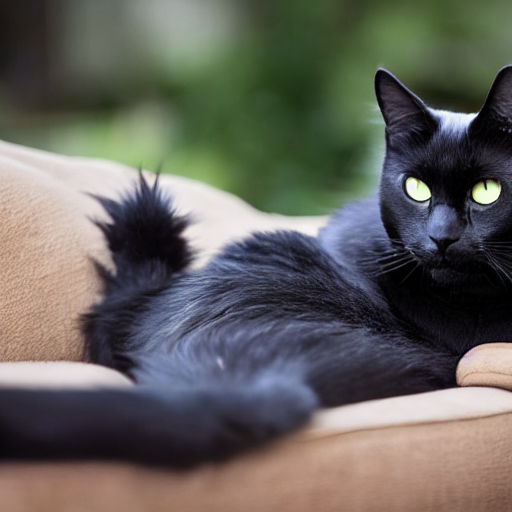

In [ ]:
stable_diffusion_tool = StableDiffusionTool()
stable_diffusion_tool.use('A photo of a black cat lounging around')

You: nick cage as an angel please


  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7A2220A62320>


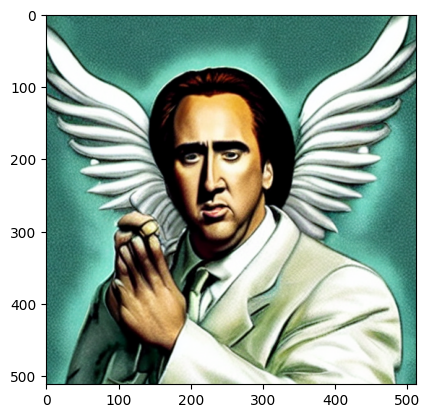

Agent: Here is the image of Nick Cage as an angel: [Image Displayed]
You: Nice! Now put him on a beach


  0%|          | 0/50 [00:00<?, ?it/s]

<PIL.Image.Image image mode=RGB size=512x512 at 0x7A221C8613F0>


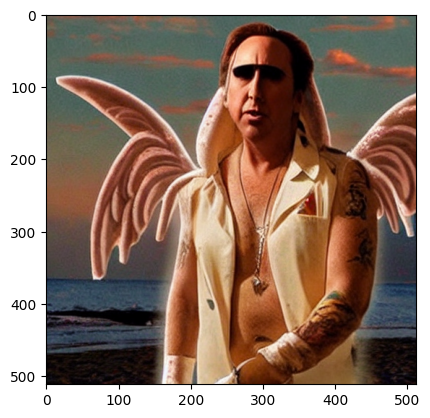

Agent: Here is the image of Nick Cage as an angel on a beach: [Image Displayed]
You: Perfect. Can you check my stock balance plaese?
Agent: Your current stock balance is Cash: $4996.53, Portfolio Value: $4996.53.
You: and one last thing. If I have this image as a file saved somewhere, can you write some code to load and flip it around 180 degrees?
Agent: Here is the Python code to load and flip an image 180 degrees. Please replace 'path_to_your_image_file.jpg' with the actual file path of the image you want to flip: 
```python
from PIL import Image

# Load the image file
image = Image.open('path_to_your_image_file.jpg')

# Flip the image 180 degrees
flipped_image = image.rotate(180)

# Save the flipped image
flipped_image.save('flipped_image.jpg')
```
You: thanks!
Agent: You're welcome! If you need any more help, feel free to ask.
You: exit

AI Responses:
User Input: nick cage as an angel please
Thought: This request seems to be asking for an image of Nick Cage as an angel.

Action: St

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    c,
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire(),
    StableDiffusionTool()
])

chat_with(sawyer)

In [ ]:
pinecone_key = userdata.get('PINECONE_API_KEY')
INDEX_NAME = 'semantic-search-test'
ENGINE = 'text-embedding-3-large'  # has size 3072
NAMESPACE = 'default'

from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(
    api_key=pinecone_key
)
# helper functions to get lists of embeddings from the OpenAI API
def get_embeddings(texts, engine=ENGINE):
    response = client.embeddings.create(
        input=texts,
        model=engine
    )

    return [d.embedding for d in list(response.data)]

def get_embedding(text, engine=ENGINE):
    return get_embeddings([text], engine)[0]

len(get_embedding('hi')), len(get_embeddings(['hi', 'hello']))

(3072, 2)

In [ ]:
import hashlib
def my_hash(s):
    # Return the MD5 hash of the input string as a hexadecimal string
    return hashlib.md5(s.encode()).hexdigest()

my_hash('I love to hash it')

'ae76cc4dfd345ecaeea9b8ba0d5c3437'

In [ ]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)
index

In [ ]:
# Store the index as a variable
index = pc.Index(name=INDEX_NAME)

def query_from_pinecone(query, top_k=3, include_metadata=True):
    # get embedding from THE SAME embedder as the documents
    query_embedding = get_embedding(query, engine=ENGINE)

    return index.query(
      vector=query_embedding,
      top_k=top_k,
      namespace=NAMESPACE,
      include_metadata=include_metadata   # gets the metadata (dates, text, etc)
    ).get('matches')

query_from_pinecone('who is the nigerian president?')

[{'id': '0471c62e0a4e00ee0dd94692afd804cb',
  'metadata': {'date_uploaded': '2024-02-04T15:47:06.778538',
               'text': 'Ali Bongo Ondimba (born Alain Bernard Bongo; 9 February '
                       '1959), sometimes known as Ali Bongo, is a Gabonese '
                       'politician who has been President of Gabon since '
                       'October 2009.'},
  'score': 0.41126892,
  'values': []},
 {'id': '701a83eae12f021ba7f1c485ac486986',
  'metadata': {'date_uploaded': '2024-02-04T15:47:18.035816',
               'text': 'Recep Tayyip Erdoğan (; Turkish: [ɾeˈdʒep tajˈjip '
                       'ˈæɾdo.an] (listen); born 26 February 1954) is a Turkish '
                       'politician serving as the 12th and current President of '
                       'Turkey since 2014. He previously served as Prime '
                       'Minister from 2003 to 2014 and as Mayor of Istanbul '
                       'from 1994 to 1998. He founded the Justice and '
        

In [ ]:
class LookupTool(ToolInterface):
    """A tool for performing semantic searches using Pinecone and OpenAI embeddings."""

    # Pinecone setup
    pinecone_key: str = userdata.get('PINECONE_API_KEY')
    INDEX_NAME: str = 'semantic-search-qsllm'
    ENGINE: str = 'text-embedding-3-large'  # has size 3072
    NAMESPACE: str = 'default'

    name: str = "Semantic Search Tool"
    description: str = (
        "A tool for performing information lookup. Look something up if you "
        "are being asked about a fact. Even if the retrieved information is "
        "irrelevant, mention that in the thought and answer the question."
    )

    def __init__(self, **data):
        super().__init__(**data)

    def get_embeddings(self, texts, engine=ENGINE):
        response = OpenAI(api_key=userdata.get('OPENAI_API_KEY')).embeddings.create(
            input=texts,
            model=engine
        )
        return [d.embedding for d in list(response.data)]

    def get_embedding(self, text, engine=ENGINE):
        return self.get_embeddings([text], engine)[0]

    def my_hash(self, s):
        return hashlib.md5(s.encode()).hexdigest()

    def query_from_pinecone(self, query, top_k=3, include_metadata=True):
        # get embedding from THE SAME embedder as the documents
        query_embedding = self.get_embedding(query, engine=self.ENGINE)
        index = Pinecone(api_key=userdata.get('PINECONE_API_KEY')).Index(name='semantic-search-test')

        return index.query(
          vector=query_embedding,
          top_k=top_k,
          namespace=self.NAMESPACE,
          include_metadata=include_metadata   # gets the metadata (dates, text, etc)
        ).get('matches')[0]['metadata']['text']

    def use(self, query):
        return self.query_from_pinecone(query)


In [ ]:
l = LookupTool()
l.use('what is baseball?')

'Due to historical associations with the United States, many Cubans participate in sports that are popular in North America, rather than sports traditionally played in other Latin American nations. Baseball is the most popular. Other sports and pastimes include football, basketball, volleyball, cricket, and athletics. Cuba is a dominant force in amateur boxing, consistently achieving high medal tallies in major international competitions. Cuban boxers are not permitted to turn professional by their government. However, many boxers defect to the U.S. and other countries. Cuba also provides a national team that competes in the Olympic Games.'

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), LookupTool()])
result = agent.run("please write me a function to take in a number and return 2 times it")

print(f"Final answer is {result}")

Final answer is Here is the function that takes in a number and returns 2 times that number:

```python
def double_number(num):
    return 2 * num
``` 

You can use this function by calling `double_number(your_number)` where `your_number` is the number you want to double.


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), LookupTool()])
result = agent.run("How many people are allowed on the baseball field during play?")

print(f"Final answer is {result}")

Final answer is I will now switch to using the Python REPL to find the answer to the user's question.

Action: Python REPL
Action Input: 
```python
# In baseball, there are typically 9 players on the field during play.
players_on_field = 9
print(players_on_field)
```


In [ ]:
import pandas as pd

response = supabase.table('cost_projecting').select("*").eq('app', 'AGENT').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = completions_df['created_at'].astype('datetime64[ns]')

completions_df.head()

,id,created_at,prompt,response,model,is_openai,input_tokens,output_tokens,inference_params,app
created_at,,,,,,,,,,
2024-03-19 00:11:59.767265,11,2024-03-19T00:11:59.767265+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I can use Python to search for inform...,gpt-3.5-turbo,True,263,26,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:12:00.743284,12,2024-03-19T00:12:00.743284+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: It seems like the Wikipedia module is...,gpt-3.5-turbo,True,300,48,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:11:55.053282,7,2024-03-19T00:11:55.053282+00:00,Who is the president of Turkey?,The current president of Turkey is Recep Tayyi...,gpt-3.5-turbo,True,14,16,"{'stop': None, 'temperature': 0.0}",AGENT
2024-03-19 00:11:56.293809,8,2024-03-19T00:11:56.293809+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I will define a function in Python th...,gpt-3.5-turbo,True,273,46,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:11:57.260465,9,2024-03-19T00:11:57.260465+00:00,Today is 2024-03-19 and you can use tools to g...,No output will be displayed since the function...,gpt-3.5-turbo,True,323,45,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
